In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import time
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report

2025-09-01 01:10:12.745313: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756689012.930061      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756689012.986975      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
train_dir = "/kaggle/input/coffee-bean-tanvir/train"
test_dir = "/kaggle/input/coffee-bean-tanvir/test"

# Training Data Generator (with validation split)
# ======================
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    brightness_range=[0.8,1.2],
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2   # 20% of training data for validation
)

# Training generator
train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128,128),
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
    subset='training'    # <-- this is the training subset
)

# Validation generator
val_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128,128),
    batch_size=32,
    class_mode='categorical',
    shuffle=False,
    subset='validation'  # <-- this is the validation subset
)

# ======================
# Test Data Generator (final evaluation)
# ======================
test_datagen = ImageDataGenerator(rescale=1./255)

test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=(128,128),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Quick sanity check
# ======================
print("Train classes mapping:", train_gen.class_indices)
print("Validation classes mapping:", val_gen.class_indices)
print("Test classes mapping:", test_gen.class_indices)

Found 960 images belonging to 4 classes.
Found 240 images belonging to 4 classes.
Found 400 images belonging to 4 classes.
Train classes mapping: {'Dark': 0, 'Green': 1, 'Light': 2, 'Medium': 3}
Validation classes mapping: {'Dark': 0, 'Green': 1, 'Light': 2, 'Medium': 3}
Test classes mapping: {'Dark': 0, 'Green': 1, 'Light': 2, 'Medium': 3}


In [4]:
# CBAM Block
# ======================
def cbam_block(feature_map, ratio=8):
    channel = feature_map.shape[-1]

    # Channel Attention
    shared_dense_one = layers.Dense(channel // ratio, activation='relu', kernel_initializer='he_normal', use_bias=True)
    shared_dense_two = layers.Dense(channel, kernel_initializer='he_normal', use_bias=True)

    avg_pool = layers.GlobalAveragePooling2D()(feature_map)
    avg_pool = layers.Reshape((1,1,channel))(avg_pool)
    avg_pool = shared_dense_one(avg_pool)
    avg_pool = shared_dense_two(avg_pool)

    max_pool = layers.GlobalMaxPooling2D()(feature_map)
    max_pool = layers.Reshape((1,1,channel))(max_pool)
    max_pool = shared_dense_one(max_pool)
    max_pool = shared_dense_two(max_pool)

    channel_attention = layers.Add()([avg_pool, max_pool])
    channel_attention = layers.Activation('sigmoid')(channel_attention)
    channel_refined = layers.Multiply()([feature_map, channel_attention])

    # Spatial Attention
    avg_pool_sp = layers.Lambda(lambda x: tf.reduce_mean(x, axis=3, keepdims=True))(channel_refined)
    max_pool_sp = layers.Lambda(lambda x: tf.reduce_max(x, axis=3, keepdims=True))(channel_refined)
    concat = layers.Concatenate(axis=3)([avg_pool_sp, max_pool_sp])
    spatial_attention = layers.Conv2D(1, (7,7), padding='same', activation='sigmoid')(concat)

    refined_feature = layers.Multiply()([channel_refined, spatial_attention])
    return refined_feature

In [5]:
# Build CBAM CNN
# ======================
def build_cbam_cnn(input_shape=(128,128,3), num_classes=4):
    inputs = Input(shape=input_shape)

    # Conv Block 1
    x = layers.Conv2D(32, (3,3), activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D((2,2))(x)
    x = cbam_block(x)

    # Conv Block 2
    x = layers.Conv2D(64, (3,3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = cbam_block(x)

    # Conv Block 3
    x = layers.Conv2D(128, (3,3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = cbam_block(x)

    # Global Average Pooling (feature output)
    gap = layers.GlobalAveragePooling2D()(x)

    # Dense head for training only
    dense = layers.Dense(256, activation='relu')(gap)
    dense = layers.Dropout(0.5)(dense)
    outputs = layers.Dense(num_classes, activation='softmax')(dense)

    model = models.Model(inputs, outputs)
    return model

In [6]:
num_classes = train_gen.num_classes
cbam_model = build_cbam_cnn(input_shape=(128,128,3), num_classes=num_classes)

cbam_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = cbam_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20,
    verbose=1
)

I0000 00:00:1756689025.466692      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20


I0000 00:00:1756689034.402554     113 service.cc:148] XLA service 0x7fefc8057d30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1756689034.403250     113 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1756689035.253284     113 cuda_dnn.cc:529] Loaded cuDNN version 90300


 1/30 ━━━━━━━━━━━━━━━━━━━━ 6:10 13s/step - accuracy: 0.1875 - loss: 1.3863

I0000 00:00:1756689040.263531     113 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


30/30 ━━━━━━━━━━━━━━━━━━━━ 27s 482ms/step - accuracy: 0.2258 - loss: 1.3869 - val_accuracy: 0.2500 - val_loss: 1.3862
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 255ms/step - accuracy: 0.2802 - loss: 1.3861 - val_accuracy: 0.2500 - val_loss: 1.3832
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 7s 249ms/step - accuracy: 0.2756 - loss: 1.3771 - val_accuracy: 0.3917 - val_loss: 1.2827
Epoch 4/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 7s 246ms/step - accuracy: 0.4344 - loss: 1.1599 - val_accuracy: 0.5792 - val_loss: 0.7366
Epoch 5/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 7s 247ms/step - accuracy: 0.6287 - loss: 0.6802 - val_accuracy: 0.7792 - val_loss: 0.5989
Epoch 6/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 252ms/step - accuracy: 0.6765 - loss: 0.5893 - val_accuracy: 0.6792 - val_loss: 0.6169
Epoch 7/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 258ms/step - accuracy: 0.6863 - loss: 0.5687 - val_accuracy: 0.7542 - val_loss: 0.5352
Epoch 8/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 257ms/step - accuracy: 0.7006 - loss: 0.5343 - val_accuracy: 0.8208 - val

In [7]:
# Feature Extraction (GlobalAveragePooling2D output)
# ======================
feature_extractor = models.Model(
    inputs=cbam_model.input,
    outputs=cbam_model.layers[-4].output   # GAP output before Dense
)

def extract_features(model, generator):
    features = []
    labels = []
    for i in range(len(generator)):
        x_batch, y_batch = generator[i]
        feat = model.predict(x_batch, verbose=0)
        features.append(feat)
        labels.append(np.argmax(y_batch, axis=1))
    features = np.vstack(features)
    labels = np.hstack(labels)
    return features, labels

X_train, y_train = extract_features(feature_extractor, train_gen)
X_val, y_val     = extract_features(feature_extractor, val_gen)
X_test, y_test   = extract_features(feature_extractor, test_gen)

In [8]:
# Apply StandardScaler to the extracted features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [9]:
# KNN Classifier
# ======================
knn = KNeighborsClassifier(n_neighbors=5) # You can adjust n_neighbors
knn.fit(X_train_scaled, y_train)

KNeighborsClassifier()

In [10]:
# ---- Training ----
start_time = time.time()
knn = KNeighborsClassifier(n_neighbors=5)  # Adjust n_neighbors if needed
knn.fit(X_train_scaled, y_train)
train_time = time.time() - start_time
print(f"Training Time: {train_time:.4f} seconds")

# ---- Validation ----
start_time = time.time()
y_val_pred = knn.predict(X_val_scaled)
val_time = time.time() - start_time
print(f"Validation Prediction Time: {val_time:.4f} seconds")
print("Validation Accuracy (KNN):", accuracy_score(y_val, y_val_pred))

# ---- Testing ----
start_time = time.time()
y_test_pred = knn.predict(X_test_scaled)
test_time = time.time() - start_time
print(f"Test Prediction Time: {test_time:.4f} seconds")
print("Test Accuracy (KNN):", accuracy_score(y_test, y_test_pred))

# ---- Classification Report ----
print(classification_report(y_test, y_test_pred, target_names=list(train_gen.class_indices.keys())))

Training Time: 0.0010 seconds
Validation Prediction Time: 0.0499 seconds
Validation Accuracy (KNN): 0.975
Test Prediction Time: 0.0251 seconds
Test Accuracy (KNN): 0.97
              precision    recall  f1-score   support

        Dark       0.95      0.99      0.97       100
       Green       1.00      0.97      0.98       100
       Light       0.98      0.97      0.97       100
      Medium       0.95      0.95      0.95       100

    accuracy                           0.97       400
   macro avg       0.97      0.97      0.97       400
weighted avg       0.97      0.97      0.97       400



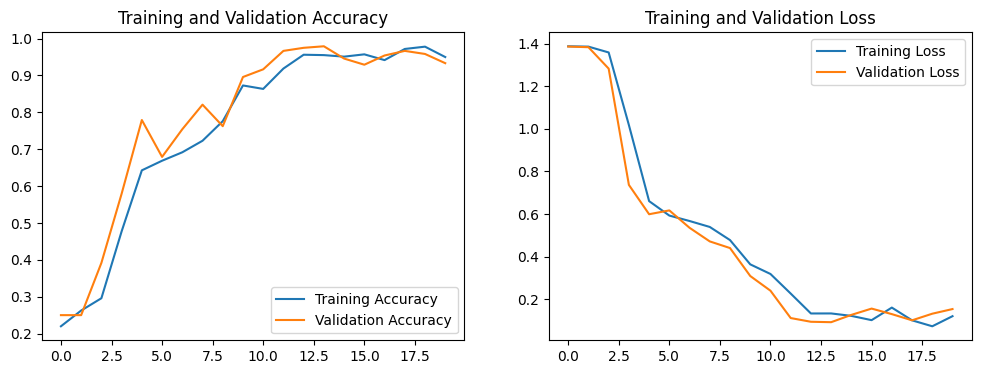

In [11]:
# Plot training and validation accuracy and loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Accuracy: 0.97
Precision: 0.9704302641802642
Recall: 0.97
F1-score: 0.9700585451893687
Confusion Matrix:
 [[99  0  0  1]
 [ 0 97  2  1]
 [ 0  0 97  3]
 [ 5  0  0 95]]


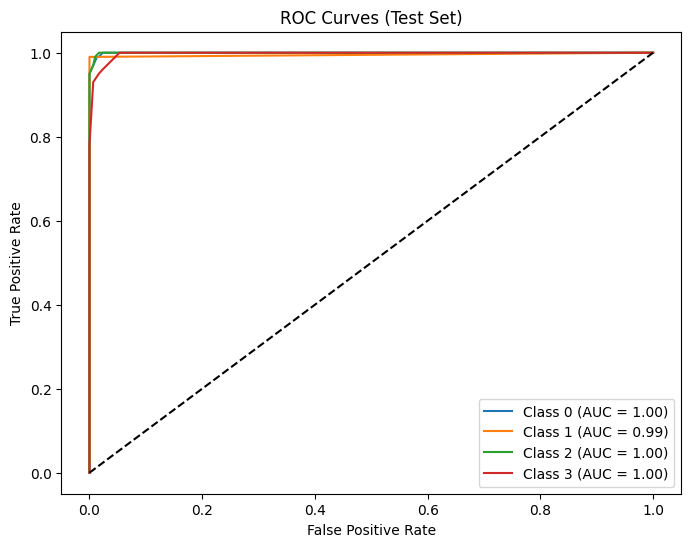

Test AUC: 0.997925


In [13]:
# ---- Predictions ----
y_test_pred = knn.predict(X_test_scaled)        
y_test_proba = knn.predict_proba(X_test_scaled) 

# ---- Basic Metrics ----
print("Accuracy:", accuracy_score(y_test, y_test_pred))
print("Precision:", precision_score(y_test, y_test_pred, average='macro'))
print("Recall:", recall_score(y_test, y_test_pred, average='macro'))
print("F1-score:", f1_score(y_test, y_test_pred, average='macro'))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))

# ---- ROC-AUC Curves ----
# Binarize labels for multi-class ROC
classes_present = np.unique(y_test)
y_test_bin = label_binarize(y_test, classes=classes_present)

# Only plot ROC if at least 2 classes are present
if y_test_bin.shape[1] > 1:
    plt.figure(figsize=(8,6))
    for i in range(y_test_bin.shape[1]):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_test_proba[:, i])
        plt.plot(fpr, tpr, label=f"Class {classes_present[i]} (AUC = {auc(fpr, tpr):.2f})")
    plt.plot([0,1],[0,1],'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curves (Test Set)")
    plt.legend()
    plt.show()

    # Compute overall ROC-AUC
    print("Test AUC:", roc_auc_score(y_test_bin, y_test_proba, multi_class='ovr'))
else:
    print("ROC-AUC skipped: less than 2 classes present in test set")